### Importing Packages

In [54]:
import numpy as np
import pandas as pd
import preprocessing
import nltk

### Creating Dataframe

In [55]:
df = pd.read_csv('spam.csv', encoding = 'cp1252')

### Dropping Unnecessary Columns

In [56]:
df = df.drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

### Encoding Categorical Labels to Numerical

In [57]:
from sklearn.preprocessing import LabelEncoder

# encode categorical labels to numerical labels
encoder = LabelEncoder()
df['v1'] = encoder.fit_transform(df['v1'])

### Dropping Duplicates/Missing Data

In [58]:
# check for duplicates
df[df.duplicated()]

,v1,v2
102,0,As per your request 'Melle Melle (Oru Minnamin...
153,0,As per your request 'Melle Melle (Oru Minnamin...
206,0,"As I entered my cabin my PA said, '' Happy B'd..."
222,0,"Sorry, I'll call later"
325,0,No calls..messages..missed calls
...,...,...
5524,1,You are awarded a SiPix Digital Camera! call 0...
5535,0,"I know you are thinkin malaria. But relax, chi..."
5539,0,Just sleeping..and surfing
5553,0,Hahaha..use your brain dear


In [59]:
df['v1'].value_counts()

v1
0    4825
1     747
Name: count, dtype: int64

In [60]:
# drop duplicates
df = df.drop_duplicates()

In [61]:
# check for missing values
df.isnull().values.any()

False

### Plotting Class Densities

<Axes: title={'center': 'Occurences of Each Label'}, xlabel='Label', ylabel='Count'>

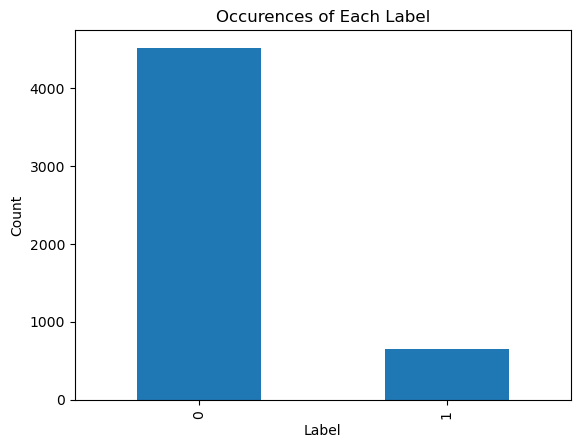

In [62]:
import matplotlib.pyplot as plt
df['v1'].value_counts().plot(kind = 'bar', xlabel = "Label", 
                             ylabel = 'Count', title = "Occurences of Each Label")

### Filtering Dataframe based on Entry Length

In [63]:
# check length of messages
df['length'] = df['v2'].apply(len)
df['length'].value_counts()

length
22     91
24     91
32     90
23     86
38     82
       ..
375     1
431     1
2       1
790     1
273     1
Name: count, Length: 274, dtype: int64

In [64]:
df = df[df['v2'].apply(lambda x: len(x) < 200)]

### Removing upper cases, punctuation, non-alphanumeric characters

In [65]:
# clean textual data
df['v2'] = preprocessing.lower(df['v2'])
df['v2'] = preprocessing.punc_removal(df['v2'])
df['v2'] = preprocessing.spec_char_removal(df['v2'])

### Tokenizing Data

In [66]:
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\alihu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [67]:
tokens = df['v2'].apply(word_tokenize)
joined_tokens = [' '.join(sentence) for sentence in tokens]

### Gaussian Naive Bayes

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, f1_score

X = df['v2']
Y = df['v1']



vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 1000)
X = vectorizer.fit_transform(joined_tokens)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

model = GaussianNB()
model.fit(X_train.toarray(), Y_train)

Y_pred = model.predict(X_test.toarray())

print(f'Accuracy: {accuracy_score(Y_test, Y_pred)}')
print(f'f1Score: {f1_score(Y_test, Y_pred)}')

Accuracy: 0.7978303747534516
f1Score: 0.5665961945031712


### Multinomial Naive Bayes

In [69]:
model = MultinomialNB()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(Y_test, Y_pred)}')
print(f'f1Score: {f1_score(Y_test, Y_pred)}')

Accuracy: 0.9743589743589743
f1Score: 0.9037037037037037


### Linear Kernel SVM

In [70]:
from sklearn.svm import SVC

svm_model = SVC(kernel = 'linear', C = 1)
svm_model.fit(X_train, Y_train)

Y_pred = svm_model.predict(X_test)

print(f'Accuracy: {accuracy_score(Y_test, Y_pred)}')
print(f'f1Score: {f1_score(Y_test, Y_pred)}')

Accuracy: 0.9723865877712031
f1Score: 0.8978102189781022


### 2nd Degree Polynomial Kernel SVM

In [71]:
svm_model = SVC(kernel = 'poly', degree = 2)
svm_model.fit(X_train, Y_train)

Y_pred = svm_model.predict(X_test)

print(f'Accuracy: {accuracy_score(Y_test, Y_pred)}')
print(f'f1Score: {f1_score(Y_test, Y_pred)}')

Accuracy: 0.9595660749506904
f1Score: 0.8404669260700389


### 3rd Degree Polynomial Kernel SVM

In [72]:
svm_model = SVC(kernel = 'poly', degree = 3)
svm_model.fit(X_train, Y_train)

Y_pred = svm_model.predict(X_test)

print(f'Accuracy: {accuracy_score(Y_test, Y_pred)}')
print(f'f1Score: {f1_score(Y_test, Y_pred)}')

Accuracy: 0.9398422090729783
f1Score: 0.7404255319148936


### Radial Basis Function Kernel SVM with width = .01

In [73]:
svm_model = SVC(kernel = 'rbf', gamma = .01)
svm_model.fit(X_train, Y_train)

Y_pred = svm_model.predict(X_test)

print(f'Accuracy: {accuracy_score(Y_test, Y_pred)}')
print(f'f1Score: {f1_score(Y_test, Y_pred)}')

Accuracy: 0.8560157790927022
f1Score: 0.0


### Radial Basis Function Kernel SVM with width = .1

In [74]:
svm_model = SVC(kernel = 'rbf', gamma = .1)
svm_model.fit(X_train, Y_train)

Y_pred = svm_model.predict(X_test)

print(f'Accuracy: {accuracy_score(Y_test, Y_pred)}')
print(f'f1Score: {f1_score(Y_test, Y_pred)}')

Accuracy: 0.9516765285996055
f1Score: 0.8016194331983806


### Radial Basis Function Kernel SVM with width = 1

In [75]:
svm_model = SVC(kernel = 'rbf', gamma = 1)
svm_model.fit(X_train, Y_train)

Y_pred = svm_model.predict(X_test)

print(f'Accuracy: {accuracy_score(Y_test, Y_pred)}')
print(f'f1Score: {f1_score(Y_test, Y_pred)}')

Accuracy: 0.9714003944773175
f1Score: 0.8921933085501859
